In [72]:
import sys
import os
sys.path.insert(0, os.path.join(os.pardir, os.pardir, 'src'))


import os.path
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

from data_processing.rat import load_rat_items
from data_processing.generate_association_matrix import load_assoc_mat
from model.stimulus import filter_valid
from data_processing.spgen import load_pointers

%matplotlib notebook

## Load experimental data

In [2]:
basedir = os.path.join(os.pardir, os.pardir)
path_file = os.path.join(basedir, 'data', 'raw', '144CompoundBowden.xlsx')
xls = pd.ExcelFile(path_file)

Load the excel sheet with values from the paper and sort RAT problems according to the t=2 condition:

In [73]:
df = xls.parse('RAT stimuli part1.csv', skip_footer=2)
df.columns = [
    'items', 'solution', '2s-%',
    '7s-%',  '7s-t-mean', '7s-t-sd',
    '15s-%', '15s-t-mean', '15s-t-sd',
    '30s-%', '30s-t-mean', '30s-t-sd']
df = df.sort_values('2s-%', ascending=False)
df = df.set_index(np.arange(len(df)))

## Load association data

In [77]:
asym, i2w, w2i = load_assoc_mat(os.path.join(basedir, 'data', 'associationmatrices'), 'freeassoc_asymmetric')
sym, _, _ = load_assoc_mat(os.path.join(basedir, 'data', 'associationmatrices'), 'freeassoc_symmetric')

In [ ]:
# A = sym + np.dot(sym, sym)
# Asym = asym + np.dot(asym, asym)

## Plot

<IPython.core.display.Javascript object>


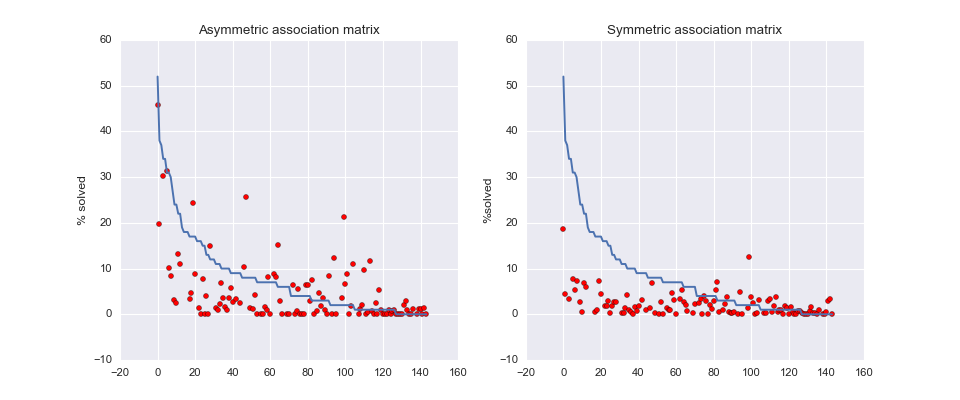

In [78]:
def solve_p(row, assoc, col_title):
    '''
    Compute probabilities for each row based on associations and store the result in col_title.
    '''
    cues = row['items'].upper().split('/')
    target = row['solution'].upper()
    
    if not all(w in i2w for w in cues+[target]):
        row[col_title] = np.nan
    else:
        ws = (1., 1., 1/1.5)
        strengths = np.max([ws[i]*assoc[w2i[cue], :] for i, cue in enumerate(cues)], axis=0)
        for cue in cues:
            strengths[w2i[cue]] = 0.
            
        normed = strengths / np.sum(strengths)
        row[col_title] = 140 * normed[w2i[target]]
        
    return row

df = df.apply(solve_p, args=(asym, 'asym'), axis=1)
df = df.apply(solve_p, args=(sym, 'sym'), axis=1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(df['2s-%'].values)
plt.scatter(np.arange(len(df)), df['asym'], c='r')
plt.ylabel('% solved')
plt.title('Asymmetric association matrix')

plt.subplot(1, 2, 2)
plt.plot(df['2s-%'].values)
plt.scatter(np.arange(len(df)), df['sym'], c='r')
plt.ylabel('%solved')
plt.title('Symmetric association matrix')

Find all problems which were easy for the model, define them as problems with ID's greater than 40 and solution rates greater than 12%

In [79]:
print('Easy problems for the model but not for humans:')
df[np.logical_and((df['asym']>10).values, df.index>40)][['items', 'solution', '2s-%', 'asym']]

Easy problems for the model but not for humans:


,items,solution,2s-%,asym
46,horse/human/drag,race,8,10.240433
47,sage/paint/hair,brush,8,25.551628
64,right/cat/carbon,copy,6,15.224490
94,river/note/account,bank,2,12.326764
99,fur/rack/tail,coat,2,21.226018
104,test/runner/map,road,2,11.071800
113,cat/number/phone,call,1,11.758421


In [80]:
print sm.OLS(df.dropna()['asym'].values, df.dropna()['2s-%'].values).fit().summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     141.7
Date:                Wed, 20 Jan 2016   Prob (F-statistic):           4.49e-21
Time:                        14:37:45   Log-Likelihood:                -332.73
No. Observations:                 104   AIC:                             667.5
Df Residuals:                     103   BIC:                             670.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.5747      0.048     11.906      0.0

## Correlation

<IPython.core.display.Javascript object>


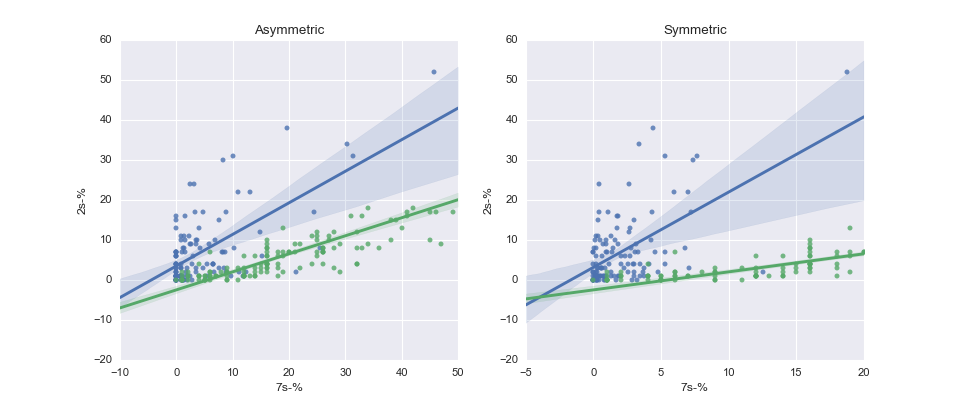

In [82]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.regplot(df['asym'], df['2s-%'])
sns.regplot(df['7s-%'], df['2s-%'])
plt.title('Asymmetric')
plt.subplot(1, 2, 2)
sns.regplot(df['sym'], df['2s-%'])
sns.regplot(df['7s-%'], df['2s-%'])
plt.title('Symmetric')


In [83]:
print sm.OLS(df.dropna()['sym'].values, df.dropna()['2s-%'].values).fit().summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     120.0
Date:                Wed, 20 Jan 2016   Prob (F-statistic):           5.60e-19
Time:                        14:38:06   Log-Likelihood:                -239.64
No. Observations:                 104   AIC:                             481.3
Df Residuals:                     103   BIC:                             483.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.2160      0.020     10.955      0.0

In [84]:
print sm.OLS(df.dropna()['7s-%'].values, df.dropna()['2s-%'].values).fit().summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     830.3
Date:                Wed, 20 Jan 2016   Prob (F-statistic):           4.20e-51
Time:                        14:38:22   Log-Likelihood:                -384.10
No. Observations:                 104   AIC:                             770.2
Df Residuals:                     103   BIC:                             772.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             2.2792      0.079     28.815      0.0